# CAMERA Workshop 2019

Daniela Ushizima, Alexandre de Siqueira, Stéfan van der Walt

_BIDS @ University of California, Berkeley_

_Lawrence Berkeley National Laboratory - LBNL_

* Support material for the tutorial _Image processing for microCT using scikit-image (Part II)_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite software](preparation.md) beforehand.

For more info:
  * [[CAMERA Workshop 2019]](http://microct.lbl.gov/cameratomo2019/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from skimage import io

In [3]:
input_filename="../data/bead_pack_artifacts_small.tif"
img = io.imread(input_filename)

In [ ]:
# uncomment if using Google colaboratory
#!wget https://github.com/dani-lbnl/imagexd19/blob/master/dip/data/bead_pack.tif?raw=true

In [ ]:
#!mv bead_pack.tif?raw=true bead_pack.tif

In [ ]:
#!ls *.tif

In [ ]:
#img = io.imread('bead_pack.tif')

## Basic image summary

In [4]:
print('* Shape: '+str(img.shape))
print('* Type: ' +str(img.dtype))
print('* Range: '+str(img.min())+','+ str(img.max()))

* Shape: (200, 200, 200)
* Type: uint8
* Range: 29,239


## Skim through

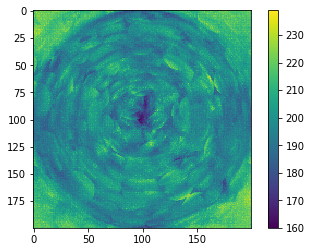

In [5]:
# Max projection is a fast way to pick on your stack content globally
x,_,_ = img.shape
IM_MAX = img[0,:,:]
for n in np.arange(1,x):
    IM_MAX = np.maximum(IM_MAX, img[n,:,:])
plt.imshow(IM_MAX)    
plt.colorbar()

In [6]:
#View each slice of original stack

from ipywidgets import interact,IntSlider

downsample = 1 #change to larger number if image shape > 1k 

def slicer(z):
    plt.imshow(img[z,::downsample,::downsample], cmap='gray')

interact(slicer, z=IntSlider(min=0, max=len(img), step=1, value=len(img)//2));

interactive(children=(IntSlider(value=100, description='z', max=200), Output()), _dom_classes=('widget-interac…

We will use the function slicer several times, so then let's create a way to quickly call it:

In [7]:
def slicing(b,lut='viridis'):
    def slicer(z):
        plt.imshow(b[z,:,:],cmap=lut, vmin=np.min(b), vmax=np.max(b)) #without vmin/vmax = dynamic :(
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));

## Exercise: non-uniform background
- calculate the mean projection of the stack
- plot a downsampled mean projection with 1/3 total number of pixels

In [8]:
# %load solutions/ex01.py

In [9]:
# %load solutions/ex02.py

## Is the intensity distribution bimodal? 

In [10]:
from skimage.util import img_as_ubyte
from skimage import data
from skimage.exposure import histogram


def seeHistSlice(img,nslice):
    noisy_image = img_as_ubyte(img[nslice,:,:])
    hist, hist_centers = histogram(noisy_image)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    ax[0].imshow(noisy_image, cmap=plt.cm.gray, vmin=0, vmax=np.max(img))
    ax[0].set_title('Slice at the middle of the stack')
    ax[0].axis('off')

    ax[1].plot(hist_centers, hist, lw=2)
    ax[1].set_title('Histogram of grey values')
    ax[1].grid()

    plt.tight_layout()
    

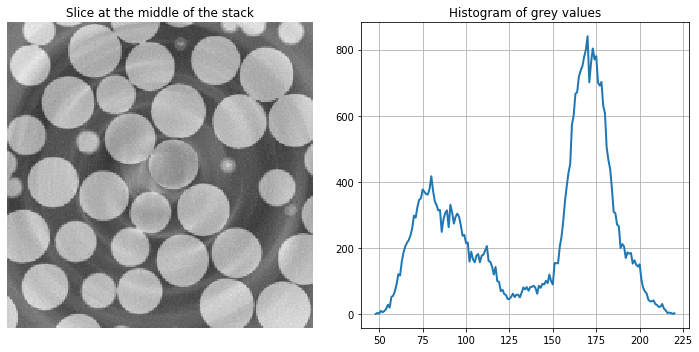

In [11]:
#Change nslice
nslice = len(img)//2 
seeHistSlice(img,nslice)

Now let's put a scroll bar to visualize stack

In [12]:
def slicingHist(b):
    def slicer(z):
        seeHistSlice(b,z)
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));    

In [13]:
slicingHist(img)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Adjust exposure
- skimage.exposure.cumulative_distribution(image) 
- skimage.exposure.equalize(*args, **kwargs) 
- skimage.exposure.equalize_adapthist(image[, ...]) 
- skimage.exposure.equalize_hist(image[, nbins]) 
- skimage.exposure.histogram(image[, nbins]) 
- skimage.exposure.rescale_intensity(image[, ...]) 

In [14]:
#Equalization for volume data, although you might be skiming through your data 
from skimage import exposure
a = exposure.equalize_hist(img)
slicing(a,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

The Laplace operator or Laplacian is a differential operator given by the divergence of the gradient of a function on Euclidean space. In a Cartesian coordinate system, the Laplacian is given by the sum of second partial derivatives of the function with respect to each independent variable.

In [15]:
#Find the edges of an image using Laplacian
from skimage import filters as fi
img2 = fi.laplace(img)
slicing(img2,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Exercise: use other filters
- Explore [[skimage.filters.rank]](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html?highlight=rank#module-skimage.filters.rank) and apply to the 3D stack (suggestion: mean_bilateral, enhance_contrast)

In [16]:
# %load solutions/ex03.py

In [17]:
# %load solutions/ex04.py

# Scipy ndimage
- Multi-dimensional image processing/analysis: filters, interpolation, measurements
- https://docs.scipy.org/doc/scipy/reference/ndimage.html

In [18]:
#Let's run a median filter on our stack
from scipy import ndimage as ndi
from skimage.morphology import ball

aball = ball(radius=2) #3D structure element
median = ndi.median_filter(img,footprint=aball) 

In [19]:
slicing(median,'gray')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Exercise
- Transform raw image into a morphologically dilated one, using grayscale dilation 

In [20]:
# %load solutions/ex05.py

# Segmentation
- categorize pixels into different 'classes' based on intensity values
- next examples will use a single cut-off, but often +1 are more effective
- mask an image

See slice: 100


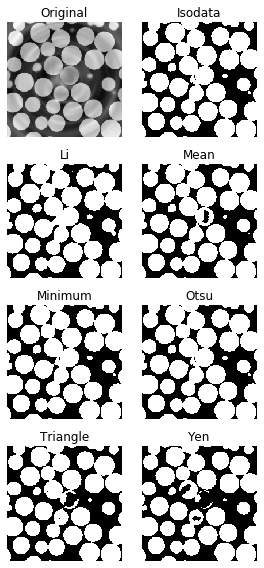

In [21]:
# checking the middle of the stack
n=len(img)//2 #middle
print("See slice: " + str(n))
aslice = median[n,:,:]

fi.try_all_threshold(aslice, figsize=(4,8), verbose=False)
plt.savefig("thresholdAll.png", bbox_inches='tight')

In [22]:
#warning: box-forced is removed in Matplotlib 3.1
import matplotlib
matplotlib.__version__

'3.1.1'

In [ ]:
# After checking an adequate method, apply to the full tack and create BINARY version
t=fi.threshold_isodata(bilat)
binary = bilat>t

slicing(binary,'gray')

## Masking and visualization

In [ ]:
def slicingMask(orig,binary):
    def slicer(z):
        plt.imshow(orig[z,:,:]*binary[z,:,:],cmap='gray',vmin=0, vmax=np.max(orig))
    interact(slicer, z=IntSlider(min=0,max=len(orig)-1,step=1,value=len(orig)//2));    

In [ ]:
# masking
slicingMask(img,binary)

## Exercises:
- Use function skimage.measure.label to create a labeled stack and output the number of connected components
    - imshow or slide between slice 68 and 69: how to fix it??
- Create a function that returns the largest connected component from a stack

In [73]:
#%load solutions/ex06.py

In [ ]:
# %load solutions/ex07.py

In [77]:
# %load solutions/ex08.py

# Clean up binary representation 

In [78]:
from skimage import morphology
aball = morphology.ball(radius=5) #aggressive

In [79]:
#3D Mathematical morphology
bin_e=morphology.binary_erosion(binary,selem=aball)
bin_o=morphology.binary_opening(binary,selem=aball)

In [80]:
#show two 2D images side by side for quick comparison
def imshowcmp(before,after,lut):
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(before,cmap=lut)
    ax[1].imshow(after,cmap=lut)

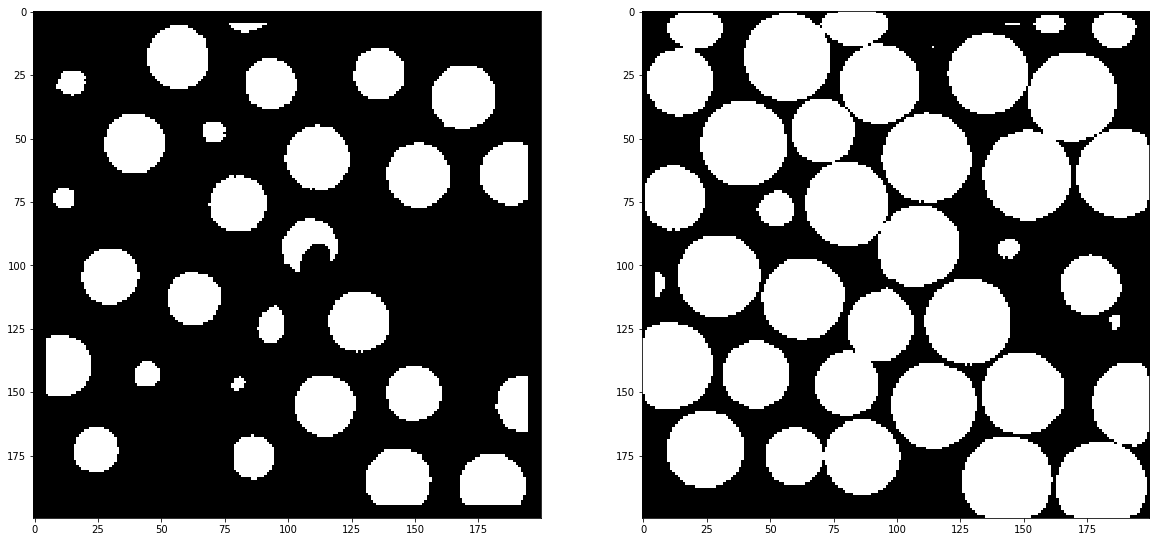

In [81]:
imshowcmp(bin_e[n,:,:],bin_o[n,:,:],'gray')

In [82]:
binary=bin_e

In [83]:
labeled = label(binary.astype('int'),connectivity=2)
print(np.max(labeled))

slicing(labeled,'rainbow')
#do not fully trust what you see here

265


interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Remove small objects

In [84]:
cleaned = morphology.remove_small_objects(binary, min_size=5000, connectivity=1, in_place=False)

labeled = label(cleaned,connectivity=2)
print(np.max(labeled))


166


## Fill holes

In [87]:
cleaned = morphology.remove_small_holes(cleaned, min_size=100, connectivity=1, in_place=True)
labeled = label(cleaned,connectivity=2)
nobjects = np.max(labeled)
print('Estimated number of objects in the stack:'+str(nobjects))

Estimated number of objects in the stack:166


In [88]:
slicing(labeled,'rainbow')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [94]:
# How to get a single object using labeled data?

loc = ndi.find_objects(labeled==50)[0]
bead = cleaned[loc]
bead.shape
np.sum(bead) #area

9148

## Inspecting connected components:
- Create a graph where x=label number and y=volume of bead in pels
- Estimate the number of beads

Text(0.5, 1.0, 'Median Volume on Eroded stack=8465.0')

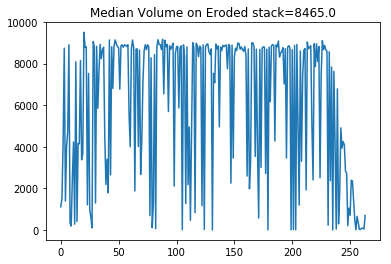

In [95]:
labeled = label(binary)
allBeads = ndi.find_objects(labeled)
nobjects = np.max(labeled)

accum = np.zeros(nobjects)
for i in np.arange(nobjects):
    loc = allBeads[i]
    bead = binary[loc]
    accum[i-1] = np.sum(bead)
plt.plot(accum)
plt.title('Median Volume on Raw Binary='+str(np.median(accum)))

Text(0.5, 1.0, 'Median Volume on Eroded stack=8787.0')

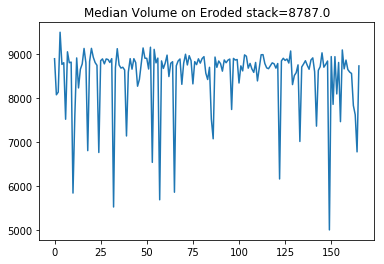

In [96]:
from skimage import segmentation
cleaned = segmentation.clear_border(cleaned)
labeled = label( cleaned )
allBeads = ndi.find_objects(labeled)
nobjects = np.max(labeled)
accum = np.zeros(nobjects)
for i in np.arange(nobjects):
    loc = allBeads[i]
    bead = binary[loc]
    accum[i-1] = np.sum(bead)
plt.plot(accum)
plt.title('Median Volume on Eroded stack='+str(np.median(accum)))

In [97]:
print('Estimated number of objects in the stack: '+str(np.sum(cleaned) / 8816))

Estimated number of objects in the stack: 160.531873866


## Checkpoints

In [118]:
from skimage.external import tifffile
path = "../data/cleaned.tiff"
tifffile.imsave(path,img_as_ubyte(cleaned))

In [119]:
path = "../data/labeled.tiff"
tifffile.imsave(path,img_as_ubyte(labeled))

Possible sign loss when converting negative image of type int64 to positive image of type uint8.
Downcasting int64 to uint8 without scaling because max value 166 fits in uint8


In [120]:
path = "../data/bead.tiff"
tifffile.imsave(path,img_as_ubyte(bead))